In [1]:
from collections import Counter
import json
import math
import os
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

### 1. Data preprocessing
+ 1.1 observation and cleaning
+ 1.2 splitting
+ 1.3 numpy or dataloader

+ download: [Kaggle link](https://www.kaggle.com/datasets/hershyandrew/amzn-dpz-btc-ntfx-adjusted-may-2013may2019)
+ info:
    + columns:
        + AMZN: Amazon
        + DPZ: Domino-Pizza
        + BTC: Bit-Coin-Center
        + NFLX: Netflix
    + 4 inputs -> 4 outputs
+ Dimension:
    + B = batch size
    + S = sequence length = L = Position
    + W = embedding dimension = E = d_model
+ More:
    + [Pytorch official Positional Encoding (S,B,W)](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) Used here
    + [Pytorch official Multi-Head Attention (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
    + [Pytorch official Transformer Encoder (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)
    + [Pytorch official Transformer (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) Used here
    + [Decoder input 1](https://zhuanlan.zhihu.com/p/107586681), [Decoder input2](https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1)

### Data observation and cleaning

In [2]:
df = pd.read_csv("./portfolio_data.csv")
df

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285
...,...,...,...,...,...
1515,5/8/2019,1917.770020,283.149994,6171.959961,364.369995
1516,5/9/2019,1899.869995,282.160004,6358.290039,362.750000
1517,5/10/2019,1889.979980,278.369995,7191.359863,361.040009
1518,5/13/2019,1822.680054,273.880005,7980.129883,345.260010


In [3]:
# change date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# check time delta
time_delta_list = []
for i in range(len(df) - 1):
    time_delta = df.loc[i + 1, "Date"] - df.loc[i, "Date"]
    time_delta_list.append(str(time_delta))
Counter(time_delta_list)

Counter({'1 days 00:00:00': 1188,
         '3 days 00:00:00': 276,
         '4 days 00:00:00': 39,
         '2 days 00:00:00': 16})

In [4]:
# check for missing values
df.isnull().sum()

Date    0
AMZN    0
DPZ     0
BTC     0
NFLX    0
dtype: int64

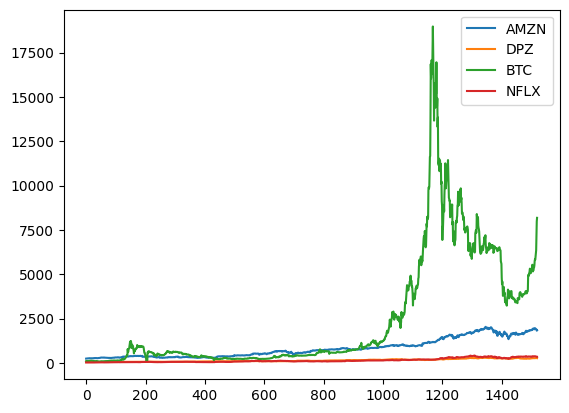

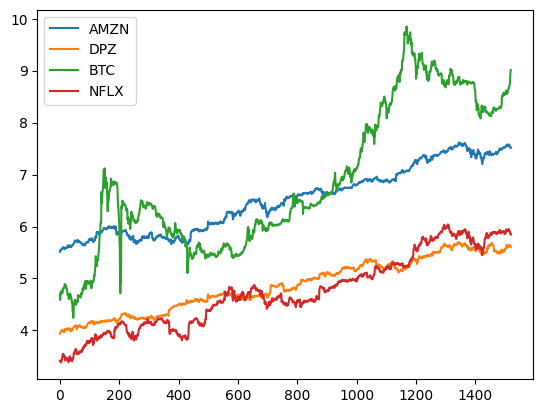

In [5]:
# raw plot
for col in df.columns:
    if col != "Date":
        plt.plot(df[col], label=col)
plt.legend()
plt.show()


# log plot
for col in df.columns:
    if col != "Date":
        plt.plot(np.log(df[col]), label=col)
plt.legend()
plt.show()

In [6]:
# filter columns
df = df.set_index("Date")

# log of values
df = df.apply(np.log)
df

,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-01,5.514356,3.935563,4.665795,3.414959
2013-05-02,5.531609,3.951000,4.585987,3.422353
2013-05-03,5.553153,3.959791,4.726502,3.417492
2013-05-06,5.544083,3.974157,4.696837,3.404478
2013-05-07,5.551913,3.991786,4.729156,3.383179
...,...,...,...,...
2019-05-08,7.558918,5.645977,8.727772,5.898170
2019-05-09,7.549541,5.642474,8.757515,5.893714
2019-05-10,7.544322,5.628951,8.880636,5.888989


In [7]:
# sliding window
window_size = 64
dataset = []
for i in range(len(df) - window_size):
    one_data = df.iloc[i: i + window_size].copy()
    # shape = (window_size, num_features) = (64, 4)

    for col in df.columns:
        one_data[f"y_{col}"] = df.iloc[i + window_size][col]
    one_data["series_id"] = i
    # shape = (window_size, num_features * 2 + 1) = (64, 9)

    dataset.append(one_data)
    
dataset = pd.concat(dataset, axis=0)
dataset

,AMZN,DPZ,BTC,NFLX,y_AMZN,y_DPZ,y_BTC,y_NFLX,series_id
Date,,,,,,,,,
2013-05-01,5.514356,3.935563,4.665795,3.414959,5.722179,4.094057,4.649187,3.572025,0
2013-05-02,5.531609,3.951000,4.585987,3.422353,5.722179,4.094057,4.649187,3.572025,0
2013-05-03,5.553153,3.959791,4.726502,3.417492,5.722179,4.094057,4.649187,3.572025,0
2013-05-06,5.544083,3.974157,4.696837,3.404478,5.722179,4.094057,4.649187,3.572025,0
2013-05-07,5.551913,3.991786,4.729156,3.383179,5.722179,4.094057,4.649187,3.572025,0
...,...,...,...,...,...,...,...,...,...
2019-05-07,7.560601,5.625425,8.699300,5.914745,7.517586,5.608959,9.009916,5.845311,1455
2019-05-08,7.558918,5.645977,8.727772,5.898170,7.517586,5.608959,9.009916,5.845311,1455
2019-05-09,7.549541,5.642474,8.757515,5.893714,7.517586,5.608959,9.009916,5.845311,1455


In [8]:
# normalization
dataset_describe = dataset.describe()
dataset_describe

,AMZN,DPZ,BTC,NFLX,y_AMZN,y_DPZ,y_BTC,y_NFLX,series_id
count,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000,93184.000000
mean,6.511656,4.865416,6.871444,4.741871,6.553074,4.899513,6.959337,4.795119,727.500000
std,0.610942,0.494716,1.359865,0.685145,0.614693,0.489436,1.337884,0.680206,420.313152
min,5.514356,3.935563,4.243626,3.383179,5.638106,4.049513,4.632785,3.560153,0.000000
25%,5.915015,4.483364,5.874313,4.149464,5.935316,4.536607,5.937299,4.167434,363.750000
50%,6.527739,4.844898,6.437816,4.644006,6.580305,4.881402,6.479661,4.688221,727.500000
75%,6.919031,5.273201,8.238693,5.235165,7.056313,5.327462,8.281870,5.275982,1091.250000
max,7.620465,5.699225,9.850736,6.037799,7.620465,5.699225,9.850736,6.037799,1455.000000


In [9]:
dataset_describe.to_csv(os.path.join(output_dir, "dataset_describe.csv"))

# keep raw data
dataset_norm = (dataset - dataset_describe.loc["mean"]) / dataset_describe.loc["std"]
dataset_norm["series_id"] = dataset["series_id"]
dataset_norm

,AMZN,DPZ,BTC,NFLX,y_AMZN,y_DPZ,y_BTC,y_NFLX,series_id
Date,,,,,,,,,
2013-05-01,-1.632396,-1.879569,-1.621961,-1.936688,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-02,-1.604155,-1.848367,-1.680649,-1.925897,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-03,-1.568891,-1.830595,-1.577319,-1.932991,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-06,-1.583738,-1.801557,-1.599133,-1.951987,-1.351724,-1.645682,-1.726720,-1.798124,0
2013-05-07,-1.570922,-1.765923,-1.575367,-1.983073,-1.351724,-1.645682,-1.726720,-1.798124,0
...,...,...,...,...,...,...,...,...,...
2019-05-07,1.716931,1.536253,1.344145,1.711864,1.569095,1.449517,1.532703,1.543932,1455
2019-05-08,1.714176,1.577796,1.365082,1.687671,1.569095,1.449517,1.532703,1.543932,1455
2019-05-09,1.698827,1.570716,1.386954,1.681167,1.569095,1.449517,1.532703,1.543932,1455


In [10]:
# splitting

seed = 0
random.seed(seed)

n_all = len(dataset) // window_size
n_train = int(n_all * 0.8)
train_indices = random.sample(list(range(n_all)), n_train)
valid_indices = list(set(range(n_all)) - set(train_indices))
train_indices_df = pd.DataFrame({"series_id": train_indices})
valid_indices_df = pd.DataFrame({"series_id": valid_indices})

train_dataset = dataset.merge(train_indices_df, on="series_id")
valid_dataset = dataset.merge(valid_indices_df, on="series_id")
train_dataset_norm = dataset_norm.merge(train_indices_df, on="series_id")
valid_dataset_norm = dataset_norm.merge(valid_indices_df, on="series_id")

train_dataset_norm.shape, valid_dataset_norm.shape

((74496, 9), (18688, 9))

In [11]:
num_input_features = 4

train_x = train_dataset_norm.iloc[:, :num_input_features].to_numpy()
valid_x = valid_dataset_norm.iloc[:, :num_input_features].to_numpy()
train_x = train_x.reshape(-1, window_size, num_input_features)
valid_x = valid_x.reshape(-1, window_size, num_input_features)

train_y = train_dataset_norm.iloc[:, num_input_features:-1].to_numpy()
valid_y = valid_dataset_norm.iloc[:, num_input_features:-1].to_numpy()
train_y = train_y[::window_size, :]
valid_y = valid_y[::window_size, :]

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((1164, 64, 4), (1164, 4), (292, 64, 4), (292, 4))

In [12]:
class ToyTimeSeriesRegressionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        """
        Args:
            x (np.ndarray): shape = (num_data, window_size, num_input_features)
            y (torch.Tensor): shape = (num_data, window_size, num_output_features)
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            x (torch.Tensor): shape = (window_size, num_input_features)
            y (torch.Tensor): shape = (num_output_features,)
        """
        return self.x[index], self.y[index]


trainset = ToyTimeSeriesRegressionDataset(train_x, train_y)
validset = ToyTimeSeriesRegressionDataset(valid_x, valid_y)
trainset[0]

(tensor([[-1.6324, -1.8796, -1.6220, -1.9367],
         [-1.6042, -1.8484, -1.6806, -1.9259],
         [-1.5689, -1.8306, -1.5773, -1.9330],
         [-1.5837, -1.8016, -1.5991, -1.9520],
         [-1.5709, -1.7659, -1.5754, -1.9831],
         [-1.5649, -1.7572, -1.5780, -1.9665],
         [-1.5556, -1.7708, -1.5467, -1.9129],
         [-1.5339, -1.7582, -1.5597, -1.9043],
         [-1.5284, -1.7502, -1.5872, -1.8279],
         [-1.5050, -1.7244, -1.5688, -1.7990],
         [-1.5158, -1.7715, -1.5435, -1.7413],
         [-1.5308, -1.7955, -1.5113, -1.7801],
         [-1.4954, -1.7740, -1.5131, -1.7680],
         [-1.5092, -1.8040, -1.5150, -1.7646],
         [-1.5017, -1.7959, -1.5095, -1.7797],
         [-1.5380, -1.8080, -1.4948, -1.8332],
         [-1.5453, -1.7172, -1.4563, -1.8484],
         [-1.5457, -1.7340, -1.4624, -1.8320],
         [-1.5113, -1.7019, -1.4610, -1.9279],
         [-1.5221, -1.7148, -1.4804, -1.9201],
         [-1.5141, -1.6975, -1.4803, -1.8713],
         [-1.

In [13]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=False, shuffle=False)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=False, shuffle=False)

### 2. Model prepatation
+ 2.1 model
+ 2.2 loss
+ 2.3 more hyperparameters

In [ ]:
# model

model_name = "LSTM"
#model_name = "Transformer"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
class ToyTimeSeriesRegressionLSTM(torch.nn.Module):
    def __init__(
            self,
            window_size: int,
            num_input_features: int,
            num_output_features: int,
            hidden_size: int = 64
        ):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size = num_input_features,
            hidden_size = hidden_size,
            num_layers = 3,
            batch_first = True,
        )
        self.flatten = torch.nn.Flatten(start_dim = 1)
        self.dense = torch.nn.Linear(hidden_size * window_size, num_output_features)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape=(batch_size, window_size, num_input_features)
        Returns:
            x (torch.Tensor): shape=(batch_size, num_output_features)
        """
        x, (_, _) = self.lstm(x)  # shape = (batch_size, window_size, hidden_size)
        x = self.flatten(x)  # shaoe = (batch_size, window_size * hidden_size)
        x = self.dense(x)
        return x
    

if model_name == "LSTM":
    example_x, example_y = next(iter(trainset))
    window_size, num_input_features = example_x.shape 
    num_output_features = example_y.numel()
    model = ToyTimeSeriesRegressionLSTM(
            window_size,
            num_input_features,
            num_output_features,
            hidden_size = 32
        ).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    print(model(example_x).shape)

ToyTimeSeriesRegressionLSTM(
  (lstm): LSTM(4, 32, num_layers=3, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=2048, out_features=4, bias=True)
)
num_parameters: 29956


In [ ]:
class PositionalEncoding(torch.nn.Module):
    """
    PE(pos, i)
        where pos = 0, 1, 2, ..., window_size - 1
        and i = 0, 1, 2, ..., num_input_features - 1
    
    for i = even -> sin(pos / 10000 ** (2 * i / num_input_features))
    for i = odd  -> cos(pos / 10000 ** (2 * i / num_input_features))

    Notes:
        + window_size = content length = sequence length
        + num_input_features = d_model = encoding size = embedding size
    """
    def __init__(self, num_input_features: int, max_len: int = 5000):
        """
        max_len has same axis as window_size. that means it supports all window_size within 1~5000.
        """
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)   # shape = (max_len, 1). i.e. [[0],[1],[2],...,[5000]]
        div_term = torch.exp(torch.arange(0, num_input_features, 2) * (-math.log(10000.0) / num_input_features))
        # div_term (divisor_term): shape = (num_features // 2,)
        # e.g. torch.arange(0, num_input_features=4, 2) = [0, 2]
        # e.g. div_term = exp([0, 2] * (-log(10000) / 4))
        # = [exp(-0 / 4 * log(10000)), exp(-2 / 4 * log(10000))]
        # = [10000 ** -0 / 4, 10000 ** -2 / 4]
        # = [1 / 10000 ** 0 / 4, 1 / 10000 ** 2 / 4]
        
        pe = torch.zeros(max_len, num_input_features)
        pe[:, 0::2] = torch.sin(position * div_term)   # shape = (max_len, num_input_features) = (5000, 4)
        pe[:, 1::2] = torch.cos(position * div_term)   # shape = (max_len, num_input_features) = (5000, 4)
        
        self.register_buffer('pe', pe)  # remain at cpu and non-trainable
    

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): shape = (batch_size, window_size, features)
        Returns:
            x (torch.Tensor): same shape as above
        """
        window_size = x.shape[1]
        return x + self.pe[:window_size, :].unsqueeze(0)


class ToyTransformerEncoder(torch.nn.Module):
    def __init__(self, window_size: int, num_input_features: int, num_output_features: int):
        super().__init__()
        self.positional_encoding = PositionalEncoding(num_input_features)
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model = num_input_features,
            nhead = 2,
            dim_feedforward = 64,
            batch_first = True
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.flatten = torch.nn.Flatten(start_dim = 1)
        self.dense = torch.nn.Linear(num_input_features * window_size, num_output_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (batch_size, window_size, num_input_features)
        Returns:
            x (torch.Tensor): shape = (batch_size, num_output_features)
        """
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x


if model_name == "Transformer":
    example_x, example_y = next(iter(trainset))
    window_size, num_input_features = example_x.shape 
    num_output_features = example_y.numel()
    model = ToyTransformerEncoder(
        window_size,
        num_input_features,
        num_output_features
    ).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    print(model(example_x).shape)

In [17]:
# loss
loss_func = torch.nn.MSELoss()

# more hyperparama
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
save_ckpts_per_epochs = 30

### 3. Training
+ 3.1 epoch: train loop, valid loop, save ckpts and loss
+ 3.2 check convergence

In [ ]:
history = {"train_loss_list": [], "valid_loss_list": []}
for epoch in tqdm(range(epochs)):
    # training loop
    train_loss= 0.
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()      # 1. zero the parameter gradients
        pred = model(x)            # 2. f(x) and f'(x)
        loss = loss_func(pred, y)  # 3. compute loss
        loss.backward()            # 4. send loss to torch
        optimizer.step()           # 5. update model parameters by torch loss 
        train_loss += loss.item() / len(trainset)
        
    # validation
    valid_loss = 0.
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_func(pred, y)
            valid_loss += loss.item() / len(validset)
            
    # save
    history["train_loss_list"].append(train_loss)
    history["valid_loss_list"].append(valid_loss)
    with open(os.path.join(output_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)
    if valid_loss == min(history["valid_loss_list"]):
        torch.save(model.state_dict(), os.path.join(output_dir, "best.pt"))
    elif (epoch + 1) % save_ckpts_per_epochs == 0:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"epoch_{str(epoch).zfill(3)}.pt")
        )

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


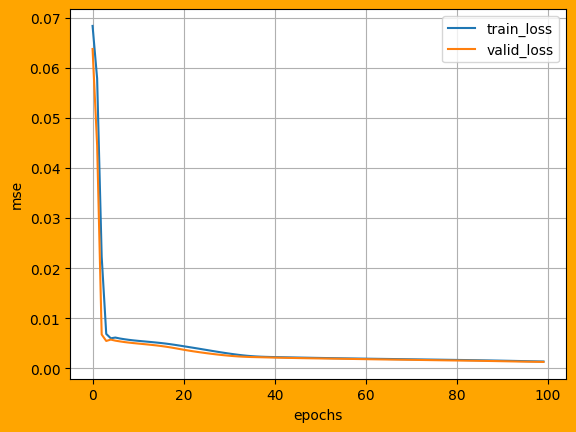

In [19]:
# check convergence
history = json.load(open(os.path.join(output_dir, "history.json")))
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['train_loss_list'], label='train_loss')
plt.plot(history['valid_loss_list'], label='valid_loss')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

### 4. Prediction
+ 4.1 testset
+ 4.2 (optional) metrics
+ 4.3 (optional) data improvement

In [ ]:
# load checkpoints and inference

ckpt_path = os.path.join(output_dir, "best.pt")
train_dataset_result = train_dataset.copy().apply(np.exp)
trainloader = trainloader
valid_dataset_result = valid_dataset.copy().apply(np.exp)
validloader = validloader

model = ToyTimeSeriesRegressionLSTM(
        window_size,
        num_input_features,
        num_output_features,
        hidden_size = 32
    ).to(device)
# model = ToyTransformerEncoder(
#         window_size,
#         num_input_features,
#         num_output_features,
#     ).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()
loss_func = torch.nn.MSELoss(reduction="none")

for dataset_result, loader, name in [
        (train_dataset_result, trainloader, "train"),
        (valid_dataset_result, validloader, "valid")
    ]:
    prediction_list = []
    loss_list = []
    for x, y in loader:
        with torch.no_grad():
            pred = model(x)
            loss = loss_func(pred, y)
            prediction_list.append(pred.cpu().numpy())  # (B, 4)
            loss_list.append(loss.cpu().numpy())  # (B, 4)
    preds = np.concatenate(prediction_list)  # (N, num_output_features)
    preds_repeat = np.repeat(preds, window_size, axis=0)  # (window_size * N, num_output_features)
    loss = np.concatenate(loss_list)
    loss_repeat = np.repeat(loss, window_size, axis=0)
    dataset_result[[f"pred_{i}" for i in range(num_output_features)]] = preds_repeat
    dataset_result[[f"loss_{i}" for i in range(num_output_features)]] = loss_repeat
    dataset_result.to_csv(os.path.join(output_dir, f"{name}_dataset_result.csv"))
    print(dataset_result)

              AMZN         DPZ          BTC        NFLX       y_AMZN  \
0       248.229996   51.190983   106.250000   30.415714   305.570007   
1       252.550003   51.987320    98.099998   30.641428   305.570007   
2       258.049988   52.446388   112.900002   30.492857   305.570007   
3       255.720001   53.205257   109.599998   30.098572   305.570007   
4       257.730011   54.151505   113.199997   29.464285   305.570007   
...            ...         ...          ...         ...          ...   
74491  1921.000000  277.390015  5998.709961  370.459991  1840.119995   
74492  1917.770020  283.149994  6171.959961  364.369995  1840.119995   
74493  1899.869995  282.160004  6358.290039  362.750000  1840.119995   
74494  1889.979980  278.369995  7191.359863  361.040009  1840.119995   
74495  1822.680054  273.880005  7980.129883  345.260010  1840.119995   

            y_DPZ        y_BTC      y_NFLX  series_id    pred_0    pred_1  \
0       59.982754   104.500000   35.588570        1.0 -1.6

In [ ]:
# (optional) metrics

ckpt_path = os.path.join(output_dir, "best.pt")
train_x_tensor = torch.tensor(train_x[:50, :, :], dtype=torch.float32).to(device)

model = ToyTimeSeriesRegressionLSTM(
        window_size,
        num_input_features,
        num_output_features,
        hidden_size = 32
    ).to(device)
# model = ToyTransformerEncoder(
#         window_size,
#         num_input_features,
#         num_output_features,
#         hidden_size = 32
#     ).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()

explainer = shap.DeepExplainer(model, train_x_tensor)
shap_values = explainer.shap_values(train_x_tensor, check_additivity=False)
shap_values.shape

/Users/james.chao/miniconda3/envs/test/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/Users/james.chao/miniconda3/envs/test/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


(50, 64, 4, 4)

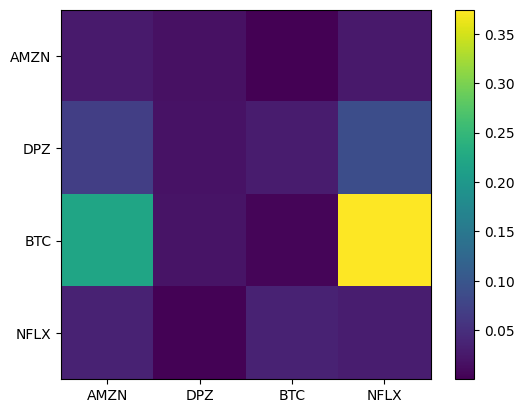

In [23]:
feature_importance = np.abs(shap_values.mean(axis=0).mean(axis=0))
feature_importance = feature_importance / feature_importance.sum()

plt.imshow(feature_importance)
plt.xticks(range(4), df.columns)
plt.yticks(range(4), df.columns)
plt.colorbar()
plt.show()

In [ ]:
# (optional) data improvement

pass